In [8]:
import pandas as pd
import seaborn as sns
import sys
import string
print('Original sys.path:', sys.path)

# Append a new directory to sys.path
sys.path.append('C:/Users/joepa/OneDrive/Desktop/computerScienceYear4/Data Mining/summary_eval/summary_eval')

# Print the updated sys.path
print('Updated sys.path:', sys.path)
from summary_eval.data import summary_df, prompts_df
from summary_eval.settings import TRAIN_SIZE
from summary_eval.testing import cross_validate

merged_df = pd.merge(summary_df, prompts_df, on='prompt_id')

Original sys.path: ['c:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval\\notebooks', 'C:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval', 'C:\\Users\\joepa\\anaconda3\\python39.zip', 'C:\\Users\\joepa\\anaconda3\\DLLs', 'C:\\Users\\joepa\\anaconda3\\lib', 'C:\\Users\\joepa\\anaconda3', 'c:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval\\venv', '', 'c:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval\\venv\\lib\\site-packages', 'c:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval\\venv\\lib\\site-packages\\win32', 'c:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval\\venv\\lib\\site-packages\\win32\\lib', 'c:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval\\venv\\lib\\site-packages\\Pythonwin', 'C:/Users/joepa/OneDrive/Desktop/computerScienceYear4/Data M

In [9]:
#PREPROCESSING
from typing import List
import re
from autocorrect import Speller
import nltk
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

def pre_process_whitespace(text: str) -> str:
    # Replace all whitespace with a single space
    text = ' '.join(text.split())
    
    # Remove leading and trailing whitespace
    text = text.strip()
    return text

merged_df["text"] = merged_df["text"].apply(lambda x: pre_process_whitespace(x))

nltk.download('punkt')

def correct_spelling(text: str) -> str:
    spell = Speller(lang='en')
    corrected_text = []
    for word in nltk.word_tokenize(text):
        corrected_text.append(spell(word))

    return ' '.join(corrected_text)

# Apply correct_spelling function to 'text' column in merged_df
#merged_df['text'] = merged_df['text'].apply(correct_spelling)

print(merged_df)



        student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0020ae56ffbf    ebad26   
2     004e978e639e    3b9047   
3     005ab0199905    3b9047   
4     0070c9e7af47    814d6b   
...            ...       ...   
7160  ff7c7e70df07    ebad26   
7161  ffc34d056498    3b9047   
7162  ffd1576d2e1b    3b9047   
7163  ffe4a98093b2    39c16e   
7164  fffbccfd8a08    ebad26   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     They would rub it up with soda to make the sme... -0.548304  0.506755   
2     In Egypt, there were many occupations and soci...  3.128928  4.231226   
3     The highest class was Pharaohs these people we... -0.210614 -0.471415   
4     The Third Wave developed rapidly because the s...  3.272894  3.219757   
...                                                 ...       ...       ...   
7160  They used all sorts of chemical concoctions to...  0.205

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
def count_specific_punctuation(text):
    punctuation_counts = {
        'num_commas': text.count(','),
        'num_quotation_marks': text.count('"'),
        'num_brackets': text.count('(') + text.count(')'),
        'num_full_stops': text.count('.')
    }
    return pd.Series(punctuation_counts)

# Apply the function to each text in the DataFrame
summary_df = pd.concat([summary_df, summary_df['text'].apply(count_specific_punctuation)], axis=1)

In [11]:
#FEATURE CREATION
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from tqdm import tqdm
tqdm.pandas()

features_df = pd.DataFrame()

features_df["num_words"] = summary_df["text"].apply(lambda x: len(word_tokenize(x)))

def count_punctuation(text):
    return sum(1 for char in text if char in string.punctuation)

features_df['punctuation_count'] = merged_df['text'].apply(count_punctuation)

def count_words(text):
    return len(text.split()) 

features_df['response_length'] = merged_df['text'].apply(count_words)

def find_similar_words(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

def count_repeated_words(response, prompt):
    repeated_words = set()
    prompt_words = set(prompt.split())
    for word in response.split():
        if word in prompt_words:
            repeated_words.add(word)
        else:
            synonyms = find_similar_words(word)
            if synonyms.intersection(prompt_words):
                repeated_words.add(word)
    return len(repeated_words)

# Calculate the number of repeated words for each response text
features_df['repeated_words_prompt_text'] = merged_df.apply(lambda row: count_repeated_words(row['text'], row['prompt_text']), axis=1)

features_df['repeated_words_prompt_question'] = merged_df.apply(lambda row: count_repeated_words(row['text'], row['prompt_question']), axis=1)

from nltk.corpus import stopwords

nltk.download('stopwords')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to count the number of stopwords in a text
def count_stopwords(text):
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stop_words)
    return stopwords_count

# Calculate the number of stopwords for each response
features_df['stopwords_count'] = merged_df['text'].apply(count_stopwords)

from collections import Counter
def calculate_repetition(text):
    # Tokenize the text into words
    words = text.lower().split()
    # Count the frequency of each word
    word_counts = Counter(words)
    # Calculate repetition metric (e.g., total number of repeated words)
    repetition = sum(count for word, count in word_counts.items() if count > 1)
    return repetition

features_df['repetition'] = merged_df['text'].apply(calculate_repetition)

from nltk.tokenize import word_tokenize

mean_word_lengths = []

# Iterate over each text in the 'text' column
for text in summary_df['text']:
    # Tokenize the text into words
    words = word_tokenize(text)
    # Calculate the mean word length for the text and append it to the mean_word_lengths list
    mean_word_lengths.append(sum(len(word) for word in words) / len(words) if words else 0)

# Add the mean word lengths as a new column in the DataFrame
features_df['mean word length'] = mean_word_lengths

def is_any_alpha(input_string):
    return any(char.isalpha() for char in input_string)

def extract_proper_nouns(text):
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    proper_nouns = set()
    for tagged_word in tagged_words:
        if isinstance(tagged_word, tuple) and tagged_word[1] == 'NNP':
            if is_any_alpha(tagged_word[0]) is True:
                proper_nouns.add(tagged_word[0])
    return list(proper_nouns)

def prop_noun_intersection(prompt_prop_nouns, summary):
    prompt_proper_nouns = set(prompt_prop_nouns)
    summary_proper_nouns = set(extract_proper_nouns(summary))
    return len(prompt_proper_nouns.intersection(summary_proper_nouns))/len(prompt_proper_nouns)

prompt_prop_nouns = {}
for i, prompt in prompts_df.iterrows():
    prompt_prop_nouns[prompt["prompt_id"]] = extract_proper_nouns(prompt["prompt_text"])

features_df["proper_noun_intersection"] = merged_df.progress_apply(lambda row: prop_noun_intersection(prompt_prop_nouns[row["prompt_id"]], row["text"]), axis=1)

def split_quotations(text: str) -> (str, List[str]):
    quotations = re.findall('"([^"]*)"', text)
    no_quote_text = text
    for quotation in quotations:
        no_quote_text = no_quote_text.replace(f'"{quotation}"', "")
    return no_quote_text, quotations

def count_quotations(text: str) -> int:
    return len(re.findall('"([^"]*)"', text))

features_df["quoteCount"] = summary_df["text"].apply(count_quotations)

def avg_quote_length(text: str) -> float:
    no_quote_text, quotations = split_quotations(text)
    if len(quotations) == 0:
        return 0
    return sum(len(q) for q in quotations) / len(quotations)

features_df["avgQuoteLength"] = summary_df["text"].apply(avg_quote_length)

from textblob import TextBlob

def get_polarity(text: str) -> float:
    blob = TextBlob(text)
    return blob.sentiment.polarity

features_df["polarity"] = summary_df["text"].progress_apply(get_polarity)

def get_subjectivity(text: str) -> float:
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

features_df["subjectivity"] = summary_df["text"].progress_apply(get_subjectivity)

def textblob_pos_filter(text: str, pos_tag: str) -> List[str]:
    blob = TextBlob(text)
    return [word for word, pos in blob.tags if pos.startswith(pos_tag)]

def count_duplicates(words: List[str]) -> dict:
    word_counts = {}
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    return word_counts

def num_adjectives_repeated(text: str) -> int:
    adjectives = textblob_pos_filter(text, "JJ")
    return len([word for word, count in count_duplicates(adjectives).items() if count >= 2])

features_df["numAdjectivesRepeated2p"] = summary_df["text"].progress_apply(num_adjectives_repeated)

def prop_adjectives_repeated_text_normalised(text: str) -> float:
    adjectives = textblob_pos_filter(text, "JJ")
    if len(adjectives) == 0:
        return None
    return len([word for word, count in count_duplicates(adjectives).items() if count >= 2]) / len(text)

features_df["propAdjectivesRepeated2pTextNormalised"] = summary_df["text"].progress_apply(prop_adjectives_repeated_text_normalised)

import textstat

def felsch_reading_ease(text: str) -> float:
    return textstat.flesch_reading_ease(text)

features_df["fleschReadingEase"] = summary_df["text"].progress_apply(felsch_reading_ease)

features_df["num_sentences"] = summary_df["text"].apply(lambda x: len(nltk.sent_tokenize(x)))
features_df["words_per_sentence"] = features_df["num_words"] / features_df["num_sentences"]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-

Adding extra features (and embeddings?)

In [13]:
#MODELS
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

X = features_df
y = merged_df[["content", "wording"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=42)

model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0))
results_df = cross_validate(model, X_train, y_train)

2024-03-16 17:33:10,848 - INFO - Using 10x10 cross validation


  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
param_grid = {
    "learning_rate": [0.1, 0.01, 0.001],
    "max_iter": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "l2_regularisation": [0, 1, 10],
}

scores = {}  # parameter combination -> mean columnwise RMSE

for learning_rate in param_grid["learning_rate"]:
    for max_iter in param_grid["max_iter"]:
        for max_depth in param_grid["max_depth"]:
            for l2_regularisation in param_grid["l2_regularisation"]:
                model = MultiOutputRegressor(
                    HistGradientBoostingRegressor(
                        learning_rate=learning_rate,
                        max_iter=max_iter,
                        max_depth=max_depth,
                        l2_regularization=l2_regularisation,
                        random_state=0,
                    )
                )
                results_df = cross_validate(model, X_train, y_train, n_folds=5, n_runs=1)
                scores[(learning_rate, max_iter, max_depth, l2_regularisation)] = results_df["rmse"]["mean_columnwise"]["mean"]

                print(
                    learning_rate,
                    max_iter,
                    max_depth,
                    l2_regularisation,
                    scores[(learning_rate, max_iter, max_depth, l2_regularisation)],
                )

{k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}



2024-03-16 17:34:48,151 - INFO - Using 1x5 cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:34:52,934 - INFO - Using 1x5 cross validation


0.1 100 None 0 0.5443627416944987


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:34:57,412 - INFO - Using 1x5 cross validation


0.1 100 None 1 0.5442830267334263


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:35:03,214 - INFO - Using 1x5 cross validation


0.1 100 None 10 0.5428499730432197


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:35:06,142 - INFO - Using 1x5 cross validation


0.1 100 5 0 0.5440921840810564


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:35:08,982 - INFO - Using 1x5 cross validation


0.1 100 5 1 0.5436710741405446


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:35:11,906 - INFO - Using 1x5 cross validation


0.1 100 5 10 0.5434252299609306


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:35:16,087 - INFO - Using 1x5 cross validation


0.1 100 10 0 0.5439115085063795


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:35:20,726 - INFO - Using 1x5 cross validation


0.1 100 10 1 0.5441438122755646


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:35:25,387 - INFO - Using 1x5 cross validation


0.1 100 10 10 0.5423476158944861


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:35:29,842 - INFO - Using 1x5 cross validation


0.1 100 20 0 0.5444496957930531


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:35:34,708 - INFO - Using 1x5 cross validation


0.1 100 20 1 0.5444853481080767


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:35:39,222 - INFO - Using 1x5 cross validation


0.1 100 20 10 0.5428339328016243


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:35:47,680 - INFO - Using 1x5 cross validation


0.1 200 None 0 0.5500676366651307


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:35:56,190 - INFO - Using 1x5 cross validation


0.1 200 None 1 0.5496523573382679


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:36:05,466 - INFO - Using 1x5 cross validation


0.1 200 None 10 0.5464225060535219


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:36:10,710 - INFO - Using 1x5 cross validation


0.1 200 5 0 0.5443495375548466


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:36:15,667 - INFO - Using 1x5 cross validation


0.1 200 5 1 0.5433974547145095


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:36:20,638 - INFO - Using 1x5 cross validation


0.1 200 5 10 0.5411716086439575


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:36:28,404 - INFO - Using 1x5 cross validation


0.1 200 10 0 0.5500165704751032


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:36:36,238 - INFO - Using 1x5 cross validation


0.1 200 10 1 0.5495183203024678


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:36:44,095 - INFO - Using 1x5 cross validation


0.1 200 10 10 0.5458167902086362


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:36:52,570 - INFO - Using 1x5 cross validation


0.1 200 20 0 0.5504451198609102


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:37:02,003 - INFO - Using 1x5 cross validation


0.1 200 20 1 0.5498722119622759


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:37:10,890 - INFO - Using 1x5 cross validation


0.1 200 20 10 0.5465399403195497


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:37:23,108 - INFO - Using 1x5 cross validation


0.1 300 None 0 0.5554526022396213


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:37:35,709 - INFO - Using 1x5 cross validation


0.1 300 None 1 0.5551297448024664


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:37:48,213 - INFO - Using 1x5 cross validation


0.1 300 None 10 0.5511656930206523


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:37:54,937 - INFO - Using 1x5 cross validation


0.1 300 5 0 0.5484610955229174


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:38:02,391 - INFO - Using 1x5 cross validation


0.1 300 5 1 0.5468386018675191


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:38:09,447 - INFO - Using 1x5 cross validation


0.1 300 5 10 0.5440020740958035


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:38:20,834 - INFO - Using 1x5 cross validation


0.1 300 10 0 0.5550570939029431


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:38:32,443 - INFO - Using 1x5 cross validation


0.1 300 10 1 0.5548476282821638


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:38:44,215 - INFO - Using 1x5 cross validation


0.1 300 10 10 0.5505502920656711


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:38:56,592 - INFO - Using 1x5 cross validation


0.1 300 20 0 0.5555025887576108


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:39:08,795 - INFO - Using 1x5 cross validation


0.1 300 20 1 0.5556375679936648


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:39:21,984 - INFO - Using 1x5 cross validation


0.1 300 20 10 0.5513809979408506


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:39:27,059 - INFO - Using 1x5 cross validation


0.01 100 None 0 0.6639144396549861


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:39:32,393 - INFO - Using 1x5 cross validation


0.01 100 None 1 0.6654608345753756


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:39:37,834 - INFO - Using 1x5 cross validation


0.01 100 None 10 0.6758311206614241


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:39:41,714 - INFO - Using 1x5 cross validation


0.01 100 5 0 0.6705293460608899


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:39:45,781 - INFO - Using 1x5 cross validation


0.01 100 5 1 0.6725015100249889


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:39:49,662 - INFO - Using 1x5 cross validation


0.01 100 5 10 0.6828906220041159


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:39:54,677 - INFO - Using 1x5 cross validation


0.01 100 10 0 0.6639098581786953


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:40:00,222 - INFO - Using 1x5 cross validation


0.01 100 10 1 0.6654608345753756


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:40:05,561 - INFO - Using 1x5 cross validation


0.01 100 10 10 0.6758311206614241


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:40:10,572 - INFO - Using 1x5 cross validation


0.01 100 20 0 0.6639144396549861


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:40:15,704 - INFO - Using 1x5 cross validation


0.01 100 20 1 0.6654608345753756


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:40:21,002 - INFO - Using 1x5 cross validation


0.01 100 20 10 0.6758311206614241


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:40:30,994 - INFO - Using 1x5 cross validation


0.01 200 None 0 0.575367815885624


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:40:41,395 - INFO - Using 1x5 cross validation


0.01 200 None 1 0.5762585131149567


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:40:51,516 - INFO - Using 1x5 cross validation


0.01 200 None 10 0.5820990011281499


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:40:59,273 - INFO - Using 1x5 cross validation


0.01 200 5 0 0.5823415261210567


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:41:06,514 - INFO - Using 1x5 cross validation


0.01 200 5 1 0.5832767608411777


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:41:13,616 - INFO - Using 1x5 cross validation


0.01 200 5 10 0.5895742606298449


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:41:23,512 - INFO - Using 1x5 cross validation


0.01 200 10 0 0.5753250585425658


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:41:33,689 - INFO - Using 1x5 cross validation


0.01 200 10 1 0.5762948319895537


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:41:43,629 - INFO - Using 1x5 cross validation


0.01 200 10 10 0.582060025830857


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:41:53,725 - INFO - Using 1x5 cross validation


0.01 200 20 0 0.575367815885624


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:42:03,961 - INFO - Using 1x5 cross validation


0.01 200 20 1 0.5762585131149567


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:42:14,135 - INFO - Using 1x5 cross validation


0.01 200 20 10 0.5820990011281499


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:42:28,758 - INFO - Using 1x5 cross validation


0.01 300 None 0 0.5539171973472862


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:42:43,334 - INFO - Using 1x5 cross validation


0.01 300 None 1 0.5542785251010376


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:42:58,450 - INFO - Using 1x5 cross validation


0.01 300 None 10 0.5569317796827119


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:43:09,029 - INFO - Using 1x5 cross validation


0.01 300 5 0 0.5590189531028311


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:43:19,589 - INFO - Using 1x5 cross validation


0.01 300 5 1 0.5595741364924585


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:43:29,801 - INFO - Using 1x5 cross validation


0.01 300 5 10 0.5633478773043923


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:43:44,169 - INFO - Using 1x5 cross validation


0.01 300 10 0 0.5538808009185571


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:43:58,325 - INFO - Using 1x5 cross validation


0.01 300 10 1 0.5542321936981374


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:44:12,816 - INFO - Using 1x5 cross validation


0.01 300 10 10 0.5568480465518311


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:44:27,073 - INFO - Using 1x5 cross validation


0.01 300 20 0 0.5539171973472862


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:44:41,409 - INFO - Using 1x5 cross validation


0.01 300 20 1 0.5542785251010376


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:44:56,715 - INFO - Using 1x5 cross validation


0.01 300 20 10 0.5569317796827119


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:45:02,116 - INFO - Using 1x5 cross validation


0.001 100 None 0 0.9776492824730907


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:45:07,275 - INFO - Using 1x5 cross validation


0.001 100 None 1 0.9781866816811751


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:45:12,453 - INFO - Using 1x5 cross validation


0.001 100 None 10 0.9810680549478861


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:45:16,404 - INFO - Using 1x5 cross validation


0.001 100 5 0 0.9789435981167411


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:45:20,563 - INFO - Using 1x5 cross validation


0.001 100 5 1 0.9795877508609137


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:45:24,057 - INFO - Using 1x5 cross validation


0.001 100 5 10 0.982138788858123


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:45:29,373 - INFO - Using 1x5 cross validation


0.001 100 10 0 0.9776492824730907


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:45:34,264 - INFO - Using 1x5 cross validation


0.001 100 10 1 0.9781866816811751


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:45:39,619 - INFO - Using 1x5 cross validation


0.001 100 10 10 0.9810680549478861


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:45:44,883 - INFO - Using 1x5 cross validation


0.001 100 20 0 0.9776492824730907


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:45:50,395 - INFO - Using 1x5 cross validation


0.001 100 20 1 0.9781866816811751


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:45:55,443 - INFO - Using 1x5 cross validation


0.001 100 20 10 0.9810680549478861


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:46:05,707 - INFO - Using 1x5 cross validation


0.001 200 None 0 0.921437571736177


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:46:15,747 - INFO - Using 1x5 cross validation


0.001 200 None 1 0.9222524910984918


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:46:25,779 - INFO - Using 1x5 cross validation


0.001 200 None 10 0.9274944614693658


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:46:33,536 - INFO - Using 1x5 cross validation


0.001 200 5 0 0.9237782044565073


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:46:41,040 - INFO - Using 1x5 cross validation


0.001 200 5 1 0.924794090979405


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:46:48,018 - INFO - Using 1x5 cross validation


0.001 200 5 10 0.9295934131544368


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:46:58,043 - INFO - Using 1x5 cross validation


0.001 200 10 0 0.921437571736177


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:47:07,985 - INFO - Using 1x5 cross validation


0.001 200 10 1 0.9222524910984918


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:47:17,850 - INFO - Using 1x5 cross validation


0.001 200 10 10 0.9274944614693658


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:47:27,886 - INFO - Using 1x5 cross validation


0.001 200 20 0 0.921437571736177


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:47:37,891 - INFO - Using 1x5 cross validation


0.001 200 20 1 0.9222524910984918


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:47:47,672 - INFO - Using 1x5 cross validation


0.001 200 20 10 0.9274944614693658


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:48:02,292 - INFO - Using 1x5 cross validation


0.001 300 None 0 0.8722143602228047


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:48:17,070 - INFO - Using 1x5 cross validation


0.001 300 None 1 0.8732990109311132


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:48:31,985 - INFO - Using 1x5 cross validation


0.001 300 None 10 0.8802844300042274


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:48:42,961 - INFO - Using 1x5 cross validation


0.001 300 5 0 0.8753502660644941


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:48:54,174 - INFO - Using 1x5 cross validation


0.001 300 5 1 0.8766730289023812


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:49:04,225 - INFO - Using 1x5 cross validation


0.001 300 5 10 0.883269486877168


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:49:19,048 - INFO - Using 1x5 cross validation


0.001 300 10 0 0.8722143602228047


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:49:34,349 - INFO - Using 1x5 cross validation


0.001 300 10 1 0.8732990109311132


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:49:49,100 - INFO - Using 1x5 cross validation


0.001 300 10 10 0.8802844300042274


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:50:03,789 - INFO - Using 1x5 cross validation


0.001 300 20 0 0.8722143602228047


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-16 17:50:18,423 - INFO - Using 1x5 cross validation


0.001 300 20 1 0.8732990109311132


  0%|          | 0/5 [00:00<?, ?it/s]

0.001 300 20 10 0.8802844300042274


{(0.1, 200, 5, 10): 0.5411716086439575,
 (0.1, 100, 10, 10): 0.5423476158944861,
 (0.1, 100, 20, 10): 0.5428339328016243,
 (0.1, 100, None, 10): 0.5428499730432197,
 (0.1, 200, 5, 1): 0.5433974547145095,
 (0.1, 100, 5, 10): 0.5434252299609306,
 (0.1, 100, 5, 1): 0.5436710741405446,
 (0.1, 100, 10, 0): 0.5439115085063795,
 (0.1, 300, 5, 10): 0.5440020740958035,
 (0.1, 100, 5, 0): 0.5440921840810564,
 (0.1, 100, 10, 1): 0.5441438122755646,
 (0.1, 100, None, 1): 0.5442830267334263,
 (0.1, 200, 5, 0): 0.5443495375548466,
 (0.1, 100, None, 0): 0.5443627416944987,
 (0.1, 100, 20, 0): 0.5444496957930531,
 (0.1, 100, 20, 1): 0.5444853481080767,
 (0.1, 200, 10, 10): 0.5458167902086362,
 (0.1, 200, None, 10): 0.5464225060535219,
 (0.1, 200, 20, 10): 0.5465399403195497,
 (0.1, 300, 5, 1): 0.5468386018675191,
 (0.1, 300, 5, 0): 0.5484610955229174,
 (0.1, 200, 10, 1): 0.5495183203024678,
 (0.1, 200, None, 1): 0.5496523573382679,
 (0.1, 200, 20, 1): 0.5498722119622759,
 (0.1, 200, 10, 0): 0.55001657

best score achieved with lr = 0.1, max_iter = 200, max_depth = 5, l2_reg = 10

2024-03-16 17:50:33,547 - INFO - Using 5x5 cross validation


  0%|          | 0/25 [00:00<?, ?it/s]

Metric        rmse                                 mae            \
Target     content   wording mean_columnwise   content   wording   
mean      0.469249   0.62177        0.545509  0.353901  0.475708   
stdev     0.011918  0.012934        0.012426  0.008848  0.010194   
n_trials        25        25               2        25        25   

Metric                          r2                            
Target   mean_columnwise   content   wording mean_columnwise  
mean            0.414805  0.796873  0.643433        0.720153  
stdev           0.009521   0.00928  0.009926        0.009603  
n_trials               2        25        25               2

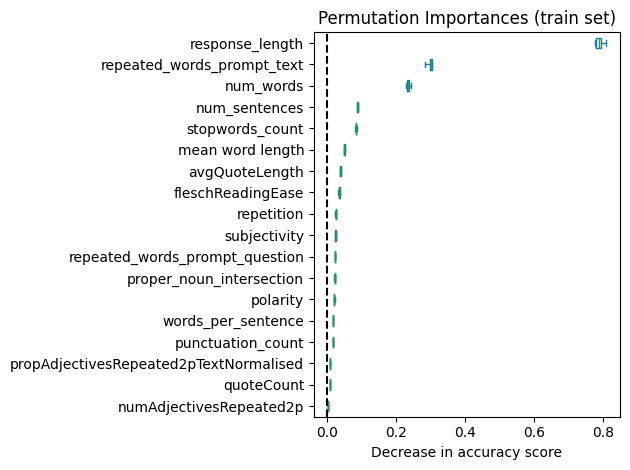

In [15]:
from sklearn.inspection import permutation_importance
model = MultiOutputRegressor(
    HistGradientBoostingRegressor(
        random_state=0,
    )
)

results_df = cross_validate(model, X_train, y_train, n_folds=5, n_runs=5)
display(results_df)

model.fit(X_train, y_train)
result = permutation_importance(
    model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


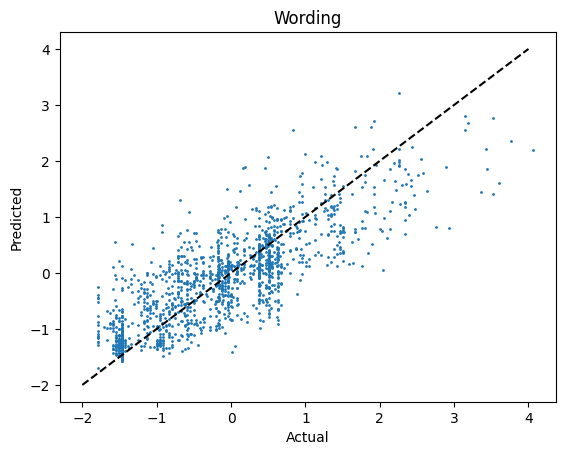

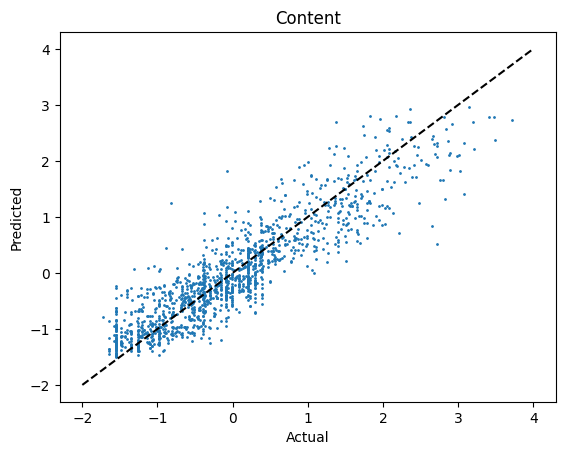

In [16]:
import matplotlib.pyplot as plt
y_test_pred = model.predict(X_test)

# plot predicted vs actual for wording, then content
plt.scatter(y_test["wording"], y_test_pred[:, 1], s=1)
plt.plot([-2, 4], [-2, 4], color="black", linestyle="--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Wording")
plt.show()

plt.scatter(y_test["content"], y_test_pred[:, 0], s=1)
plt.plot([-2, 4], [-2, 4], color="black", linestyle="--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Content")
plt.show()

2024-03-16 17:51:16,955 - INFO - Using 5x5 cross validation


  0%|          | 0/25 [00:00<?, ?it/s]

Metric        rmse                                 mae            \
Target     content   wording mean_columnwise   content   wording   
mean      0.471062  0.621285        0.546173  0.355612  0.474933   
stdev     0.011776   0.01617        0.013973  0.008564  0.012358   
n_trials        25        25               2        25        25   

Metric                          r2                            
Target   mean_columnwise   content   wording mean_columnwise  
mean            0.415272  0.795298  0.644006        0.719652  
stdev           0.010461   0.00932  0.012154        0.010737  
n_trials               2        25        25               2

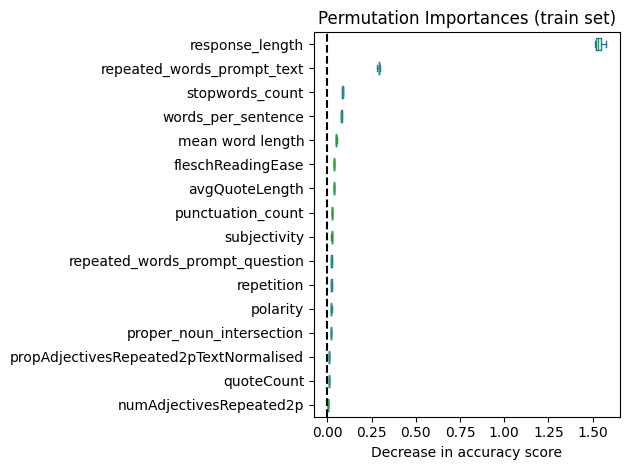

In [17]:
X_train_ss = X_train.drop(columns=["num_words", "num_sentences"])

model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0))

results_df = cross_validate(model, X_train_ss, y_train, n_folds=5, n_runs=5)
display(results_df)

model.fit(X_train_ss, y_train)
result = permutation_importance(
    model, X_train_ss, y_train, n_repeats=10, random_state=42, n_jobs=1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train_ss.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

2024-03-16 17:51:56,849 - INFO - Using 5x5 cross validation


  0%|          | 0/25 [00:00<?, ?it/s]

Metric        rmse                                 mae            \
Target     content   wording mean_columnwise   content   wording   
mean      0.544545  0.840285        0.692415  0.410144  0.654037   
stdev     0.016405  0.020287        0.018346  0.010866  0.015468   
n_trials        25        25               2        25        25   

Metric                          r2                            
Target   mean_columnwise   content   wording mean_columnwise  
mean            0.532091  0.726229   0.34851         0.53737  
stdev           0.013167  0.017901  0.028575        0.023238  
n_trials               2        25        25               2

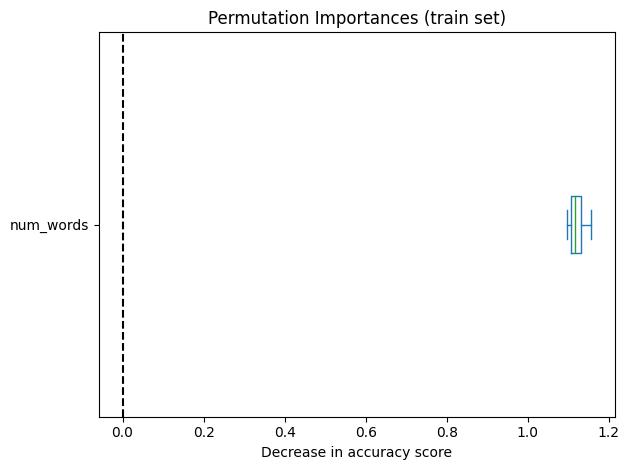

In [18]:
X_train_nw = X_train[["num_words"]]

model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0))

results_df = cross_validate(model, X_train_nw, y_train, n_folds=5, n_runs=5)
display(results_df)

model.fit(X_train_nw, y_train)
result = permutation_importance(
    model, X_train_nw, y_train, n_repeats=10, random_state=42, n_jobs=1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train_nw.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()